In [3]:
import sys
print("Python version:", sys.version.split('\n')[0])
print("Python path:", sys.executable)

import pandas as pd
import requests
print("Pandas version:", pd.__version__)
print("Requests version:", requests.__version__)

Python version: 3.10.13 (main, Oct 13 2023, 07:14:41) [Clang 12.0.0 (clang-1200.0.32.28)]
Python path: /Users/margaritaborodina/ALL_PROJECTS/PYTHON_ALL_PROJECTS/parsing/question-jupyter-notebooks/venv-cbr-parsing/bin/python
Pandas version: 2.2.3
Requests version: 2.32.3


In [3]:
!pip install lxml


In [4]:
import lxml
print("lxml is ready!")

lxml is ready!


Result: 
         date  sales  rate
0  2024-01-01   5350  16.0
1  2024-02-01   5450  16.0
2  2024-03-01   5500  16.0
3  2024-04-01   4500  16.0
4  2024-05-01   4400  16.0
5  2024-06-01   3900  16.0
6  2024-07-01   3800  18.0
7  2024-08-01   4000  18.0
8  2024-09-01   4500  19.0
9  2024-10-01   4900  21.0
10 2024-11-01   5000  21.0
11 2024-12-01   5500   NaN


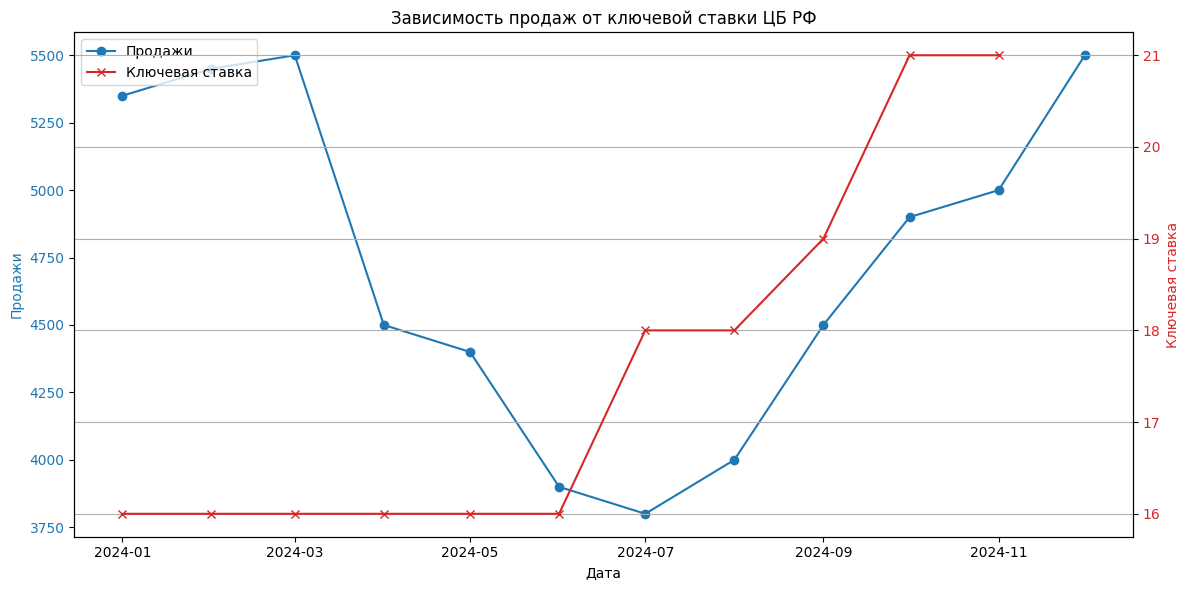


Коэффициент корреляции между продажами и ключевой ставкой: -0.05
Заметной линейной зависимости не обнаружено


In [12]:
import pandas as pd
import requests
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns

def get_key_rate_from_cbr(date_start, date_end):
    """
    Получает данные о ключевой ставке за указанный период
    :param date_start: начальная дата (объект datetime или строка)
    :param date_end: конечная дата (объект datetime или строка)
    :return: DataFrame с колонками ['date', 'rate']
    """
    # Преобразуем даты в формат DD.MM.YYYY, если они не в этом формате
    if not isinstance(date_start, str):
        date_start = date_start.strftime('%d.%m.%Y')
    if not isinstance(date_end, str):
        date_end = date_end.strftime('%d.%m.%Y')
    
    # Формируем URL с динамическими параметрами дат
    url = f"https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From={date_start}&UniDbQuery.To={date_end}"

    # url = (
    #     "https://www.cbr.ru/hd_base/keyrate/?UniDbQuery.Posted=True&UniDbQuery.From=01.05.2024&UniDbQuery.To=22.05.2025"
    # )
    
    try:
        # Отправляем GET-запрос с таймаутом
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Проверяем на ошибки HTTP

        tables = pd.read_html(StringIO(response.text), decimal=",", thousands=" ")
        df_rate = tables[0]
        df_rate.columns = ['date','rate']
        df_rate['date'] = pd.to_datetime(df_rate['date'], dayfirst=True)
        df_rate['rate'] = df_rate['rate'].astype(float)
        return df_rate
    
    except Exception as e:
        print(f"Ошибка при получении данных о ключевой ставке: {e}")
        return pd.DataFrame(columns=['date', 'rate'])  # Возвращаем пустой DataFrame при ошибке
        
def main():
    dates = pd.date_range(start='2024-01-01', end='2024-12-01', freq='MS').strftime('%Y-%m-%d')
    df_sales = pd.DataFrame({
        'date': dates,
        'sales': [5350, 5450, 5500, 4500, 4400, 3900, 3800, 4000, 4500, 4900, 5000, 5500]
    })
    df_sales['date'] = pd.to_datetime(df_sales['date'])

    date_start = df_sales['date'].min()
    date_end = df_sales['date'].max()

    df_rate = get_key_rate_from_cbr(date_start, date_end)

    if df_rate.empty:
        print("don't get the request")
        return

    df_rate_monthly = df_rate.copy() # 1. Создаём копию DataFrame, чтобы не изменять исходные данные
    df_rate_monthly['month'] = df_rate_monthly['date'].dt.to_period('M') # 2. Добавляем колонку с месяцем в формате Period('M')
    df_rate_monthly = df_rate_monthly.groupby('month')['rate'].max().reset_index()
    df_rate_monthly['date'] = df_rate_monthly['month'].dt.to_timestamp()
    df_rate_monthly = df_rate_monthly[['date', 'rate']]

 # 5. Объединяем данные о продажах и ставке
    df_merged = pd.merge(df_sales, df_rate_monthly, on='date', how='left')

    # 6. Выводим результаты
    print("Result: ")
    print(df_merged.to_string())
    plt.figure(figsize=(12, 6))

    ax1 = plt.gca()
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Продажи', color='tab:blue')
    ax1.plot(df_merged['date'], df_merged['sales'], color='tab:blue', marker='o', label='Продажи')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Ключевая ставка', color='tab:red')
    ax2.plot(df_merged['date'], df_merged['rate'], color='tab:red', marker='x', label='Ключевая ставка')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    plt.title('Зависимость продаж от ключевой ставки ЦБ РФ')
    plt.grid(True)

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.tight_layout()
    plt.show()

    correlation = df_merged[['sales', 'rate']].corr().iloc[0, 1]
    print(f"\nКоэффициент корреляции между продажами и ключевой ставкой: {correlation:.2f}")

    if correlation < -0.5:
        print("Сильная отрицательная корреляция: при росте ставки продажи снижаются")
    elif correlation > 0.5:
        print("Сильная положительная корреляция: при росте ставки продажи растут")
    else:
        print("Заметной линейной зависимости не обнаружено")


if __name__ == "__main__":
    main()
